In [83]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [84]:
# Base directory where datasets are stored
dir_baseline = '../checkpoints/result/'
dir_density_1 = '../checkpoints/result_density/'
dir_density_2 = '../checkpoints/result_Clip/'
# dir_density_2 = '../checkpoints/result_density_warmup/'
datasets = ['Beauty', 'HoneyBee', 'Jockey']


In [85]:
def parse_train_txt(train_txt_path):
    with open(train_txt_path, 'r') as file:
        lines = file.readlines()
        last_line = lines[-1].strip()
        data = last_line.split(',')
        result = {
            'PSNR': float(data[1].split(':')[-1]),
            'MS-SSIM': float(data[2].split(':')[-1]),
            'Training': float(data[3].split(':')[-1][:-1]),
            'Eval': float(data[4].split(':')[-1][:-1]),
            'FPS': float(data[5].split(':')[-1]),
            'Size': float(data[6].split(':')[-1]),
            'Gaussian_number':float(data[-1].split(':')[-1])
        }    
    return result

In [86]:

# List to store results
results_baseline = []
results_new_method_1 = []
results_new_method_2 = []

# Loop through datasets and collect data from train.txt files
def get_method_data(dir_path):
    results = []
    for dataset in datasets:
        dataset_path = os.path.join(dir_path, dataset)
        for dir_name in os.listdir(dataset_path):
            if dir_name.startswith('GaussianImage_Cholesky'):
                train_txt_path = os.path.join(dataset_path, dir_name, 'train.txt')
                result= parse_train_txt(train_txt_path)
                result['Dataset'] = dataset
                if result['Gaussian_number']>=20000:
                    results.append(result)
    return results

results_baseline = get_method_data(dir_baseline)
results_new_method_1= get_method_data(dir_density_1)
results_new_method_2= get_method_data(dir_density_2)

# Sort the results by GaussianCount before converting to DataFrame
results_sorted_baseline = sorted(results_baseline, key=lambda x: x['Gaussian_number'])
# Convert results to a DataFrame
df_baseline = pd.DataFrame(results_sorted_baseline)
# Sort the results by GaussianCount before converting to DataFrame
results_sorted_new_method_1 = sorted(results_new_method_1, key=lambda x: x['Gaussian_number'])
# Convert results to a DataFrame
df_new_method_1 = pd.DataFrame(results_sorted_new_method_1)
# Sort the results by GaussianCount before converting to DataFrame
results_sorted_new_method_2 = sorted(results_new_method_2, key=lambda x: x['Gaussian_number'])
# Convert results to a DataFrame
df_new_method_2 = pd.DataFrame(results_sorted_new_method_2)


In [87]:
def plot_gaussian_vs_metrics(df_baseline, df_new_method_1, df_new_method_2):
    for dataset in datasets:
        # 按 GaussianCount 排序确保一致
        subset_df_baseline = df_baseline[df_baseline['Dataset'] == dataset].sort_values(by='Gaussian_number')
        subset_df_new_method_1 = df_new_method_1[df_new_method_1['Dataset'] == dataset].sort_values(by='Gaussian_number')
        subset_df_new_method_2 = df_new_method_2[df_new_method_2['Dataset'] == dataset].sort_values(by='Gaussian_number')
       
        plt.figure(figsize=(11, 5))

        # 第一个子图：Gaussian count vs PSNR
        plt.subplot(1, 2, 1)

        # 添加散点图和连线
        plt.scatter(subset_df_baseline['Gaussian_number'], subset_df_baseline['PSNR'], 
                    color='blue', alpha=0.7, s=50, label='BaseLine', edgecolor='black')
        plt.scatter(subset_df_new_method_1['Gaussian_number'], subset_df_new_method_1['PSNR'], 
                    color='green', alpha=0.7, s=50, label='adaptive_control', edgecolor='black')
        plt.scatter(subset_df_new_method_2['Gaussian_number'], subset_df_new_method_2['PSNR'], 
                    color='red', alpha=0.7, s=50, label='adaptive_control_Clip', edgecolor='black')



        # 绘制连线
        plt.plot(subset_df_baseline['Gaussian_number'], subset_df_baseline['PSNR'], 
                 'b-', alpha=0.5)
        plt.plot(subset_df_new_method_1['Gaussian_number'], subset_df_new_method_1['PSNR'], 
                 'g-', alpha=0.5)
        plt.plot(subset_df_new_method_2['Gaussian_number'], subset_df_new_method_2['PSNR'], 
                 'r-', alpha=0.5)



        # 添加标题和标签
        plt.xlabel('Gaussian Number', fontsize=14, fontweight='bold')
        plt.ylabel('PSNR (dB)', fontsize=14, fontweight='bold')
        plt.title(f'{dataset} - Gaussian Number vs PSNR', fontsize=16, fontweight='bold')

        # 调整 X 轴刻度和网格
        # plt.xticks(range(4000, 10000, 2000))
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()

        # 第二个子图：Gaussian count vs MS-SSIM
        plt.subplot(1, 2, 2)
     
        plt.scatter(subset_df_baseline['Gaussian_number'], subset_df_baseline['MS-SSIM'], 
                    color='blue', alpha=0.7, s=50, label='BaseLine', edgecolor='black')
        plt.scatter(subset_df_new_method_1['Gaussian_number'], subset_df_new_method_1['MS-SSIM'], 
                    color='green', alpha=0.7, s=50, label='adaptive_control', edgecolor='black')
        plt.scatter(subset_df_new_method_2['Gaussian_number'], subset_df_new_method_2['MS-SSIM'], 
                    color='red', alpha=0.7, s=50, label='adaptive_control_Clip', edgecolor='black')


        # 绘制连线
        plt.plot(subset_df_baseline['Gaussian_number'], subset_df_baseline['MS-SSIM'], 
                 'b-', alpha=0.5)
        plt.plot(subset_df_new_method_1['Gaussian_number'], subset_df_new_method_1['MS-SSIM'], 
                 'g-', alpha=0.5)
        plt.plot(subset_df_new_method_2['Gaussian_number'], subset_df_new_method_2['MS-SSIM'], 
                 'r-', alpha=0.5)


        # 添加标题和标签
        plt.xlabel('Gaussian Number', fontsize=14, fontweight='bold')
        plt.ylabel('MS-SSIM', fontsize=14, fontweight='bold')
        plt.title(f'{dataset} - Gaussian Number vs MS-SSIM', fontsize=16, fontweight='bold')

        # 调整 X 轴刻度和网格
        # plt.xticks(range(4000, 10001, 2000))
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()

        # 布局调整
        plt.tight_layout()

        # 保存图像
        plt.savefig(f'./img_compare/{dataset}_gaussian_vs_metrics.png')

        # 显示图像
        plt.show()


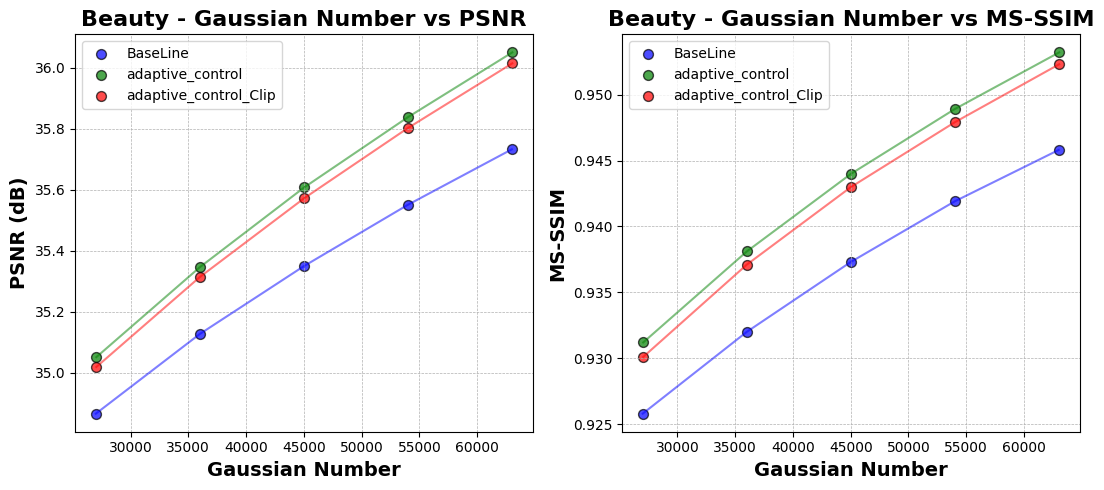

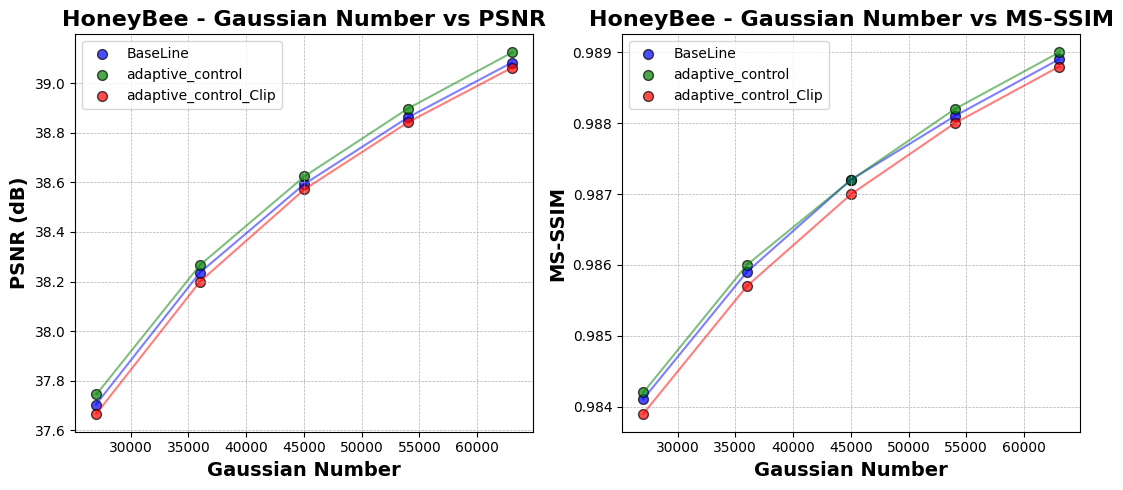

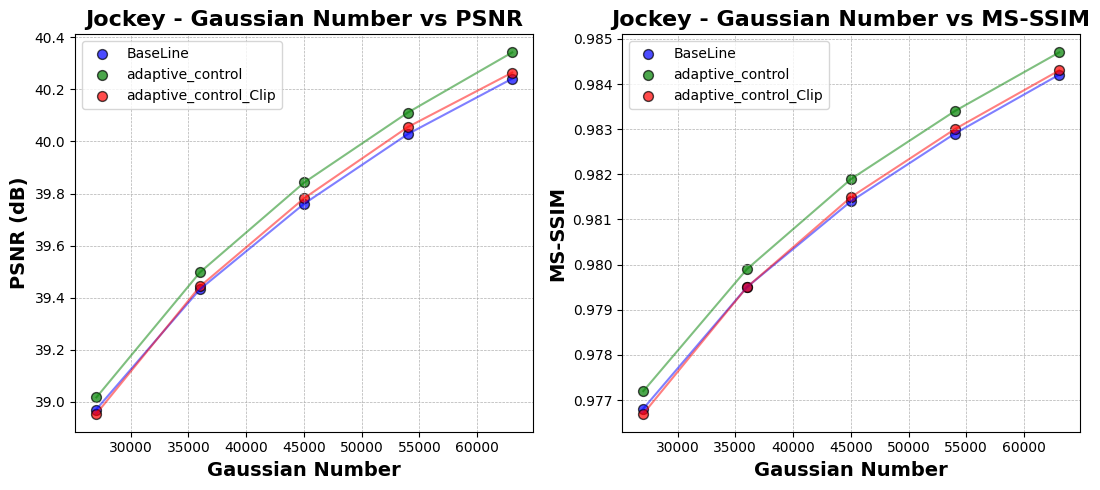

In [88]:
plot_gaussian_vs_metrics(df_baseline,df_new_method_1,df_new_method_2)